<a href="https://colab.research.google.com/github/DeepLearning-Y4/TrafficSignRecognition/blob/main/trafficsignrecognition_resnet_model__4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TrafficSignRecognition_ResNet_model



In [ ]:
# Mount Google Drive (optional if you stored the dataset there)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/gtsrb/gtsrb.zip" -d "/content/drive/MyDrive/gtsrb/traffic-sign"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00010.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00011.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00012.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00013.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00014.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00015.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00016.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00017.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00018.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_00019.png  
  inflating: /content/drive/MyDrive/gtsrb/traffic-sign/train/5/00005_00053_0002

In [ ]:
!pip install tensorflow keras matplotlib seaborn scikit-learn


In [ ]:

# ============================================
# OPTIMIZED RESNET50 FOR TRAFFIC SIGN RECOGNITION
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import os

In [ ]:

# ============================================
# 1. SETUP PATHS
# ============================================
train_dir = '/content/drive/MyDrive/gtsrb/traffic-sign/Train'
test_dir = '/content/drive/MyDrive/gtsrb/traffic-sign/Test'
test_csv_path = '/content/drive/MyDrive/gtsrb/traffic-sign/Test.csv'


In [ ]:

# ============================================
# 2. ENHANCED DATA AUGMENTATION
# ============================================
IMG_SIZE = (96, 96)  # Increased from 64x64 for better feature extraction
BATCH_SIZE = 32

# More aggressive augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=False,  # Traffic signs shouldn't be flipped
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:

# ============================================
# 3. IMPROVED MODEL ARCHITECTURE
# ============================================
def build_optimized_model(num_classes):
    # Load ResNet50 with updated input size
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(96, 96, 3)
    )

    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Enhanced classification head with regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense layer with L2 regularization
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second dense layer
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_optimized_model(train_generator.num_classes)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# ============================================
# 4. COMPILE WITH OPTIMIZED SETTINGS
# ============================================
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Higher initial LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 24,782,251 (94.54 MB)

 Trainable params: 1,193,003 (4.55 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [ ]:

# ============================================
# 5. CALLBACKS FOR BETTER TRAINING
# ============================================
callbacks = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:

# ============================================
# 6. PHASE 1: TRAIN TOP LAYERS
# ============================================
print("=" * 60)
print("PHASE 1: Training top layers only")
print("=" * 60)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

PHASE 1: Training top layers only


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.1251 - loss: 4.0016
Epoch 1: val_accuracy improved from -inf to 0.11924, saving model to best_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 297s 284ms/step - accuracy: 0.1252 - loss: 4.0012 - val_accuracy: 0.1192 - val_loss: 3.9016 - learning_rate: 0.0010
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2257 - loss: 3.0583
Epoch 2: val_accuracy did not improve from 0.11924
981/981 ━━━━━━━━━━━━━━━━━━━━ 295s 266ms/step - accuracy: 0.2257 - loss: 3.0583 - val_accuracy: 0.0760 - val_loss: 7.6520 - learning_rate: 0.0010
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2555 - loss: 2.8629
Epoch 3: val_accuracy did not improve from 0.11924
981/981 ━━━━━━━━━━━━━━━━━━━━ 258s 263ms/step - accuracy: 0.2555 - loss: 2.8628 - val_accuracy: 0.0886 - val_loss: 7.0081 - learning_rate: 0.0010
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2613 - loss: 2.7994
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.11924
981/981 ━━━━━━━━━━━━━━━━━━━━ 258s 263ms/step - accuracy: 0.2613 - loss:

981/981 ━━━━━━━━━━━━━━━━━━━━ 259s 264ms/step - accuracy: 0.2830 - loss: 2.7008 - val_accuracy: 0.1634 - val_loss: 3.5198 - learning_rate: 5.0000e-04
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2961 - loss: 2.6256
Epoch 6: val_accuracy improved from 0.16337 to 0.17141, saving model to best_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 258s 262ms/step - accuracy: 0.2961 - loss: 2.6256 - val_accuracy: 0.1714 - val_loss: 3.4029 - learning_rate: 5.0000e-04
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2987 - loss: 2.6115
Epoch 7: val_accuracy did not improve from 0.17141
981/981 ━━━━━━━━━━━━━━━━━━━━ 257s 263ms/step - accuracy: 0.2987 - loss: 2.6115 - val_accuracy: 0.1181 - val_loss: 4.2592 - learning_rate: 5.0000e-04
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3000 - loss: 2.5656
Epoch 8: val_accuracy did not improve from 0.17141
981/981 ━━━━━━━━━━━━━━━━━━━━ 256s 261ms/step - accuracy: 0.3000 - loss: 2.5656 - val_accuracy: 0.1289 - val_loss: 4.9211 - learning_rate: 5.0000e-04
Epoch 9/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3055 - loss: 2.5575
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: val_accuracy did not improve from 0.17141
981/981 ━━━━━━━━━━━━━━━━━━━━ 259s 264ms/step - accuracy: 0.

981/981 ━━━━━━━━━━━━━━━━━━━━ 261s 266ms/step - accuracy: 0.3087 - loss: 2.5232 - val_accuracy: 0.1820 - val_loss: 4.0433 - learning_rate: 2.5000e-04
Epoch 11/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3214 - loss: 2.4976
Epoch 11: val_accuracy did not improve from 0.18199
981/981 ━━━━━━━━━━━━━━━━━━━━ 255s 259ms/step - accuracy: 0.3214 - loss: 2.4976 - val_accuracy: 0.1528 - val_loss: 5.0602 - learning_rate: 2.5000e-04
Epoch 12/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3160 - loss: 2.4819
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 12: val_accuracy did not improve from 0.18199
981/981 ━━━━━━━━━━━━━━━━━━━━ 254s 259ms/step - accuracy: 0.3160 - loss: 2.4819 - val_accuracy: 0.1553 - val_loss: 3.6403 - learning_rate: 2.5000e-04
Epoch 13/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3252 - loss: 2.4445
Epoch 13: val_accuracy improved from 0.18199 to 0.20610, saving model to best_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 254s 258ms/step - accuracy: 0.3252 - loss: 2.4445 - val_accuracy: 0.2061 - val_loss: 3.0420 - learning_rate: 1.2500e-04
Epoch 14/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3297 - loss: 2.4116
Epoch 14: val_accuracy did not improve from 0.20610
981/981 ━━━━━━━━━━━━━━━━━━━━ 254s 259ms/step - accuracy: 0.3297 - loss: 2.4116 - val_accuracy: 0.1910 - val_loss: 3.0663 - learning_rate: 1.2500e-04
Epoch 15/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.3318 - loss: 2.4139
Epoch 15: val_accuracy did not improve from 0.20610
981/981 ━━━━━━━━━━━━━━━━━━━━ 256s 261ms/step - accuracy: 0.3318 - loss: 2.4139 - val_accuracy: 0.1931 - val_loss: 3.2914 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 13.


In [ ]:
# ============================================
# 7. PHASE 2: FINE-TUNING
# ============================================
print("\n" + "=" * 60)
print("PHASE 2: Fine-tuning with unfrozen layers")
print("=" * 60)

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Reset callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-8,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_finetuned_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


PHASE 2: Fine-tuning with unfrozen layers
Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1804 - loss: 3.3173
Epoch 1: val_accuracy improved from -inf to 0.20967, saving model to best_finetuned_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 314s 291ms/step - accuracy: 0.1804 - loss: 3.3169 - val_accuracy: 0.2097 - val_loss: 3.1581 - learning_rate: 1.0000e-05
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3126 - loss: 2.4632
Epoch 2: val_accuracy did not improve from 0.20967
981/981 ━━━━━━━━━━━━━━━━━━━━ 264s 269ms/step - accuracy: 0.3126 - loss: 2.4632 - val_accuracy: 0.1613 - val_loss: 3.8657 - learning_rate: 1.0000e-05
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3596 - loss: 2.2642
Epoch 3: val_accuracy improved from 0.20967 to 0.24372, saving model to best_finetuned_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 263s 268ms/step - accuracy: 0.3596 - loss: 2.2641 - val_accuracy: 0.2437 - val_loss: 2.9377 - learning_rate: 1.0000e-05
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3895 - loss: 2.1674
Epoch 4: val_accuracy did not improve from 0.24372
981/981 ━━━━━━━━━━━━━━━━━━━━ 262s 267ms/step - accuracy: 0.3895 - loss: 2.1674 - val_accuracy: 0.2407 - val_loss: 3.6404 - learning_rate: 1.0000e-05
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4035 - loss: 2.1089
Epoch 5: val_accuracy improved from 0.24372 to 0.32037, saving model to best_finetuned_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 264s 269ms/step - accuracy: 0.4035 - loss: 2.1089 - val_accuracy: 0.3204 - val_loss: 2.4821 - learning_rate: 1.0000e-05
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4211 - loss: 2.0456
Epoch 6: val_accuracy did not improve from 0.32037
981/981 ━━━━━━━━━━━━━━━━━━━━ 320s 267ms/step - accuracy: 0.4211 - loss: 2.0456 - val_accuracy: 0.2669 - val_loss: 2.9124 - learning_rate: 1.0000e-05
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4405 - loss: 1.9728
Epoch 7: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.

Epoch 7: val_accuracy did not improve from 0.32037
981/981 ━━━━━━━━━━━━━━━━━━━━ 264s 269ms/step - accuracy: 0.4405 - loss: 1.9728 - val_accuracy: 0.2475 - val_loss: 3.3255 - learning_rate: 1.0000e-05
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4748 - loss: 1.8490
Epoch 8: val_accuracy improved from 0.32037 to 0.36551, saving model to best_finetuned_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 265s 270ms/step - accuracy: 0.4748 - loss: 1.8490 - val_accuracy: 0.3655 - val_loss: 2.4651 - learning_rate: 3.0000e-06
Epoch 9/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.4846 - loss: 1.8096
Epoch 9: val_accuracy did not improve from 0.36551
981/981 ━━━━━━━━━━━━━━━━━━━━ 250s 255ms/step - accuracy: 0.4846 - loss: 1.8096 - val_accuracy: 0.3331 - val_loss: 2.5496 - learning_rate: 3.0000e-06
Epoch 10/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4966 - loss: 1.7682
Epoch 10: val_accuracy did not improve from 0.36551
981/981 ━━━━━━━━━━━━━━━━━━━━ 249s 254ms/step - accuracy: 0.4966 - loss: 1.7682 - val_accuracy: 0.3591 - val_loss: 2.4277 - learning_rate: 3.0000e-06
Epoch 11/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5112 - loss: 1.7301
Epoch 11: val_accuracy did not improve from 0.36551
981/981 ━━━━━━━━━━━━━━━━━━━━ 249s 254ms/step - accuracy: 0.5112 - loss: 1.7302 - val_accuracy: 0.3595 - val_loss: 2.3605 - learning_

981/981 ━━━━━━━━━━━━━━━━━━━━ 250s 254ms/step - accuracy: 0.5367 - loss: 1.6268 - val_accuracy: 0.4150 - val_loss: 2.1190 - learning_rate: 9.0000e-07
Epoch 17/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5526 - loss: 1.5817
Epoch 17: val_accuracy did not improve from 0.41500
981/981 ━━━━━━━━━━━━━━━━━━━━ 247s 252ms/step - accuracy: 0.5526 - loss: 1.5817 - val_accuracy: 0.3975 - val_loss: 2.0856 - learning_rate: 9.0000e-07
Epoch 18/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5542 - loss: 1.5855
Epoch 18: val_accuracy improved from 0.41500 to 0.45428, saving model to best_finetuned_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 249s 254ms/step - accuracy: 0.5542 - loss: 1.5855 - val_accuracy: 0.4543 - val_loss: 1.8919 - learning_rate: 9.0000e-07
Epoch 19/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5578 - loss: 1.5696
Epoch 19: val_accuracy did not improve from 0.45428
981/981 ━━━━━━━━━━━━━━━━━━━━ 252s 257ms/step - accuracy: 0.5578 - loss: 1.5696 - val_accuracy: 0.4381 - val_loss: 1.9466 - learning_rate: 9.0000e-07
Epoch 20/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5574 - loss: 1.5634
Epoch 20: ReduceLROnPlateau reducing learning rate to 2.6999999249710525e-07.

Epoch 20: val_accuracy did not improve from 0.45428
981/981 ━━━━━━━━━━━━━━━━━━━━ 248s 253ms/step - accuracy: 0.5574 - loss: 1.5634 - val_accuracy: 0.4497 - val_loss: 1.9615 - learning_rate: 9.0000e-07
Restoring model weights from the end of the best epoch: 18.


In [ ]:

# ============================================
# 8. PREPARE TEST DATA
# ============================================
test_df = pd.read_csv(test_csv_path)
test_df['Path'] = test_df['Path'].apply(
    lambda x: os.path.join('/content/drive/MyDrive/gtsrb/traffic-sign/', x)
)
test_df['ClassId'] = test_df['ClassId'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 12630 validated image filenames belonging to 43 classes.


In [ ]:

# ============================================
# 9. EVALUATE MODEL
# ============================================
print("\n" + "=" * 60)
print("EVALUATION RESULTS")
print("=" * 60)

# Test accuracy
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")

# Training accuracy
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"✅ Training Accuracy: {train_acc*100:.2f}%")



EVALUATION RESULTS


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.6310 - loss: 1.3379

✅ Final Test Accuracy: 62.72%
981/981 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - accuracy: 0.6137 - loss: 1.3651
✅ Training Accuracy: 61.23%


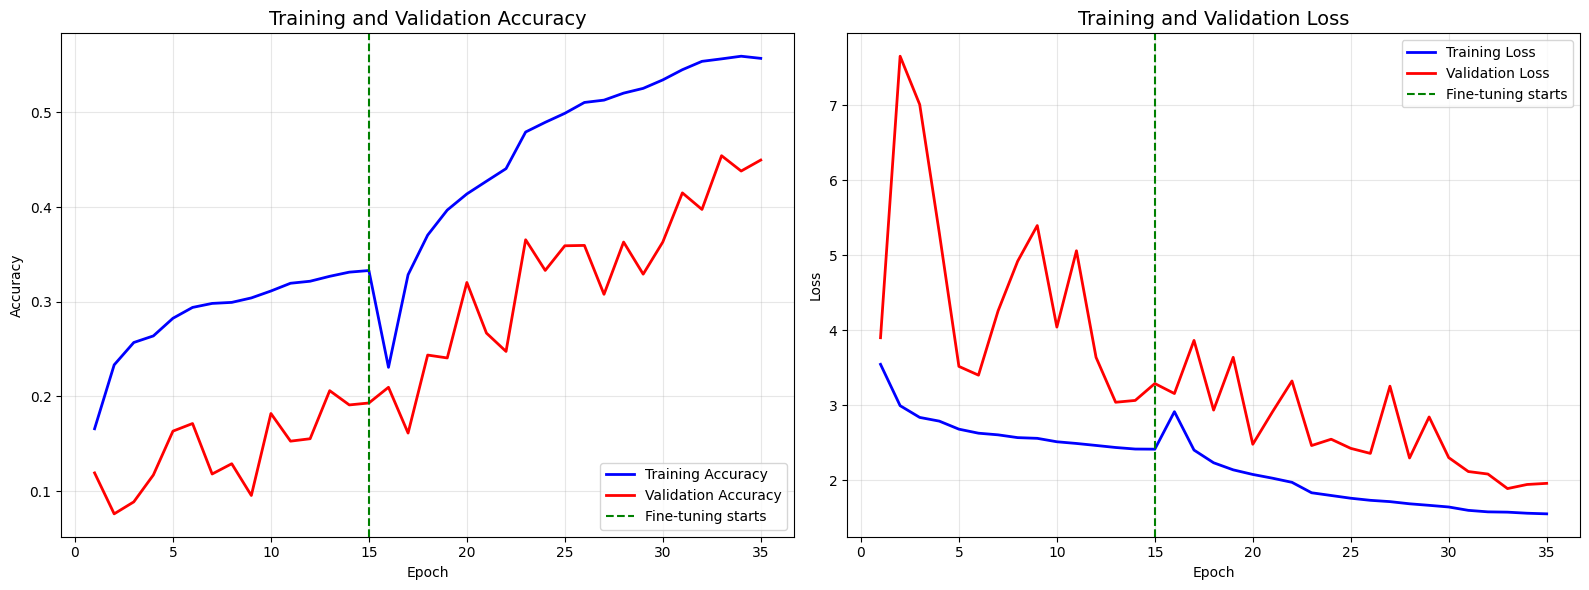

In [ ]:
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_acc*100:.2f}%")

# ============================================
# 10. PLOT TRAINING HISTORY
# ============================================
def plot_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    plt.axvline(x=len(history1.history['accuracy']), color='green',
                linestyle='--', label='Fine-tuning starts')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    plt.axvline(x=len(history1.history['loss']), color='green',
                linestyle='--', label='Fine-tuning starts')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history_phase1, history_phase2)


In [ ]:

# ============================================
# 11. CLASSIFICATION REPORT
# ============================================
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)

Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred, digits=4))



DETAILED CLASSIFICATION REPORT
395/395 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        60
           1     0.6505    0.6722    0.6612       720
           2     0.7203    0.8000    0.7581       660
           3     0.8528    0.8000    0.8256       420
           4     0.9526    0.9609    0.9567       690
           5     0.9847    0.9833    0.9840       720
           6     0.8907    0.8148    0.8511       270
           7     0.9340    0.9429    0.9384       210
           8     0.9674    0.5933    0.7355       150
           9     0.9570    0.8028    0.8731       360
          10     0.4817    0.7103    0.5741       390
          11     0.2759    0.1333    0.1798        60
          12     0.4724    0.4560    0.4640       750
          13     0.0000    0.0000    0.0000        90
          14     0.8049    0.3667    0.5038        90
          15     0.4573    0.6250    0.5282       120
     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report & Confusion Matrix

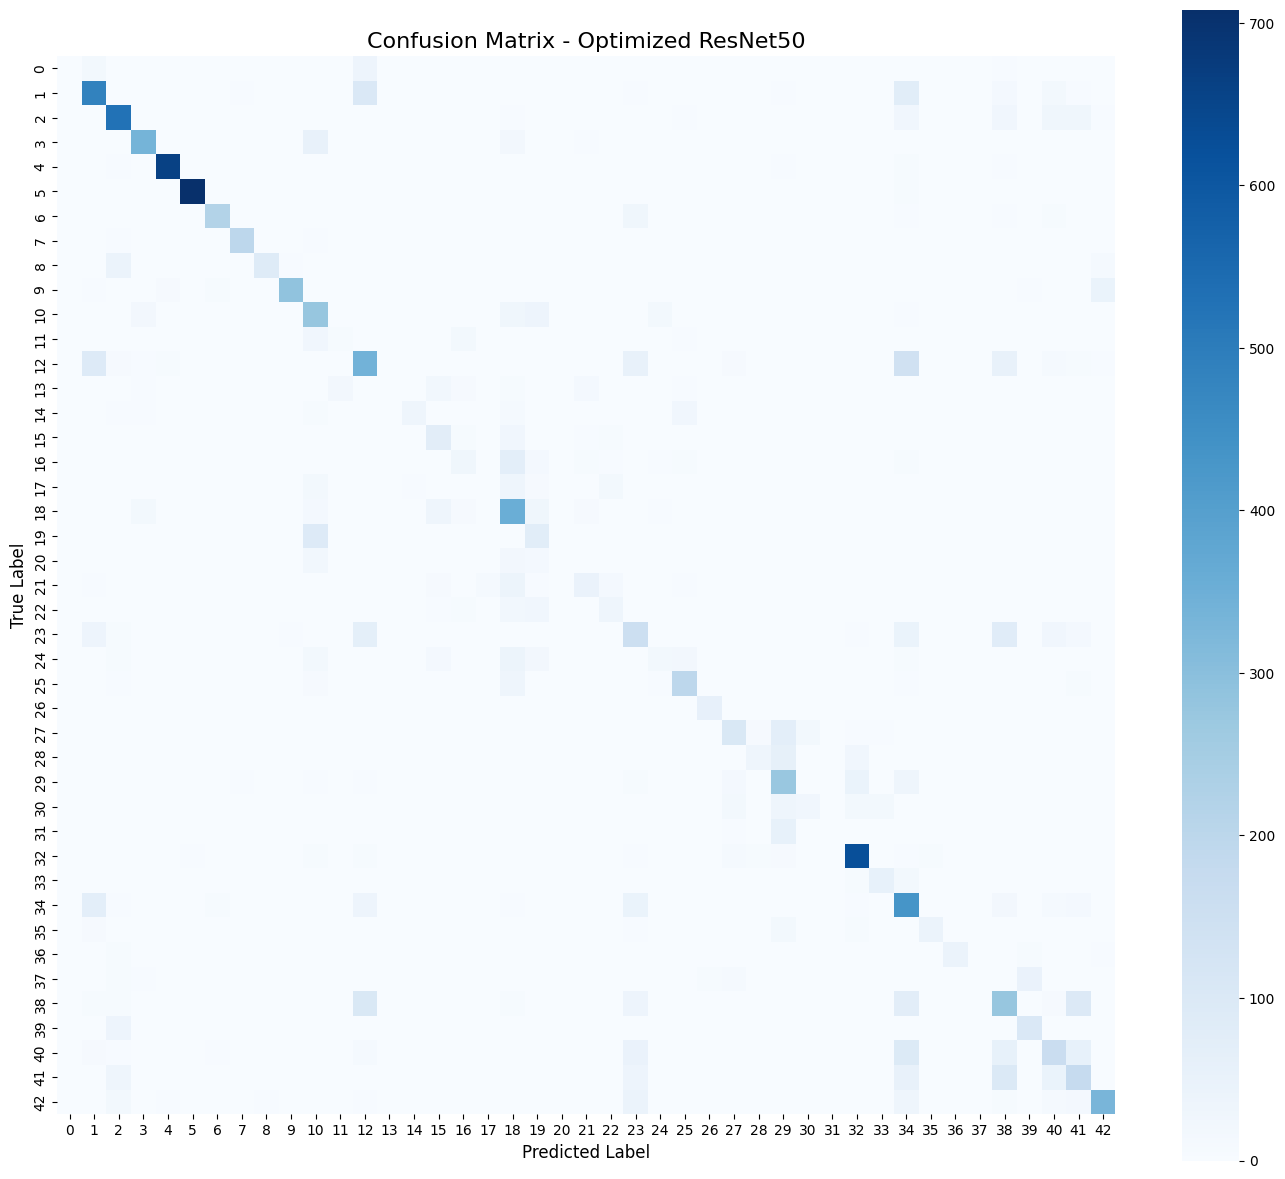

In [ ]:

# ============================================
# 12. CONFUSION MATRIX
# ============================================
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap='Blues', cbar=True, square=True,
            xticklabels=range(43), yticklabels=range(43))
plt.title("Confusion Matrix - Optimized ResNet50", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()




Number of misclassified images: 4709 out of 12630
Error rate: 37.28%


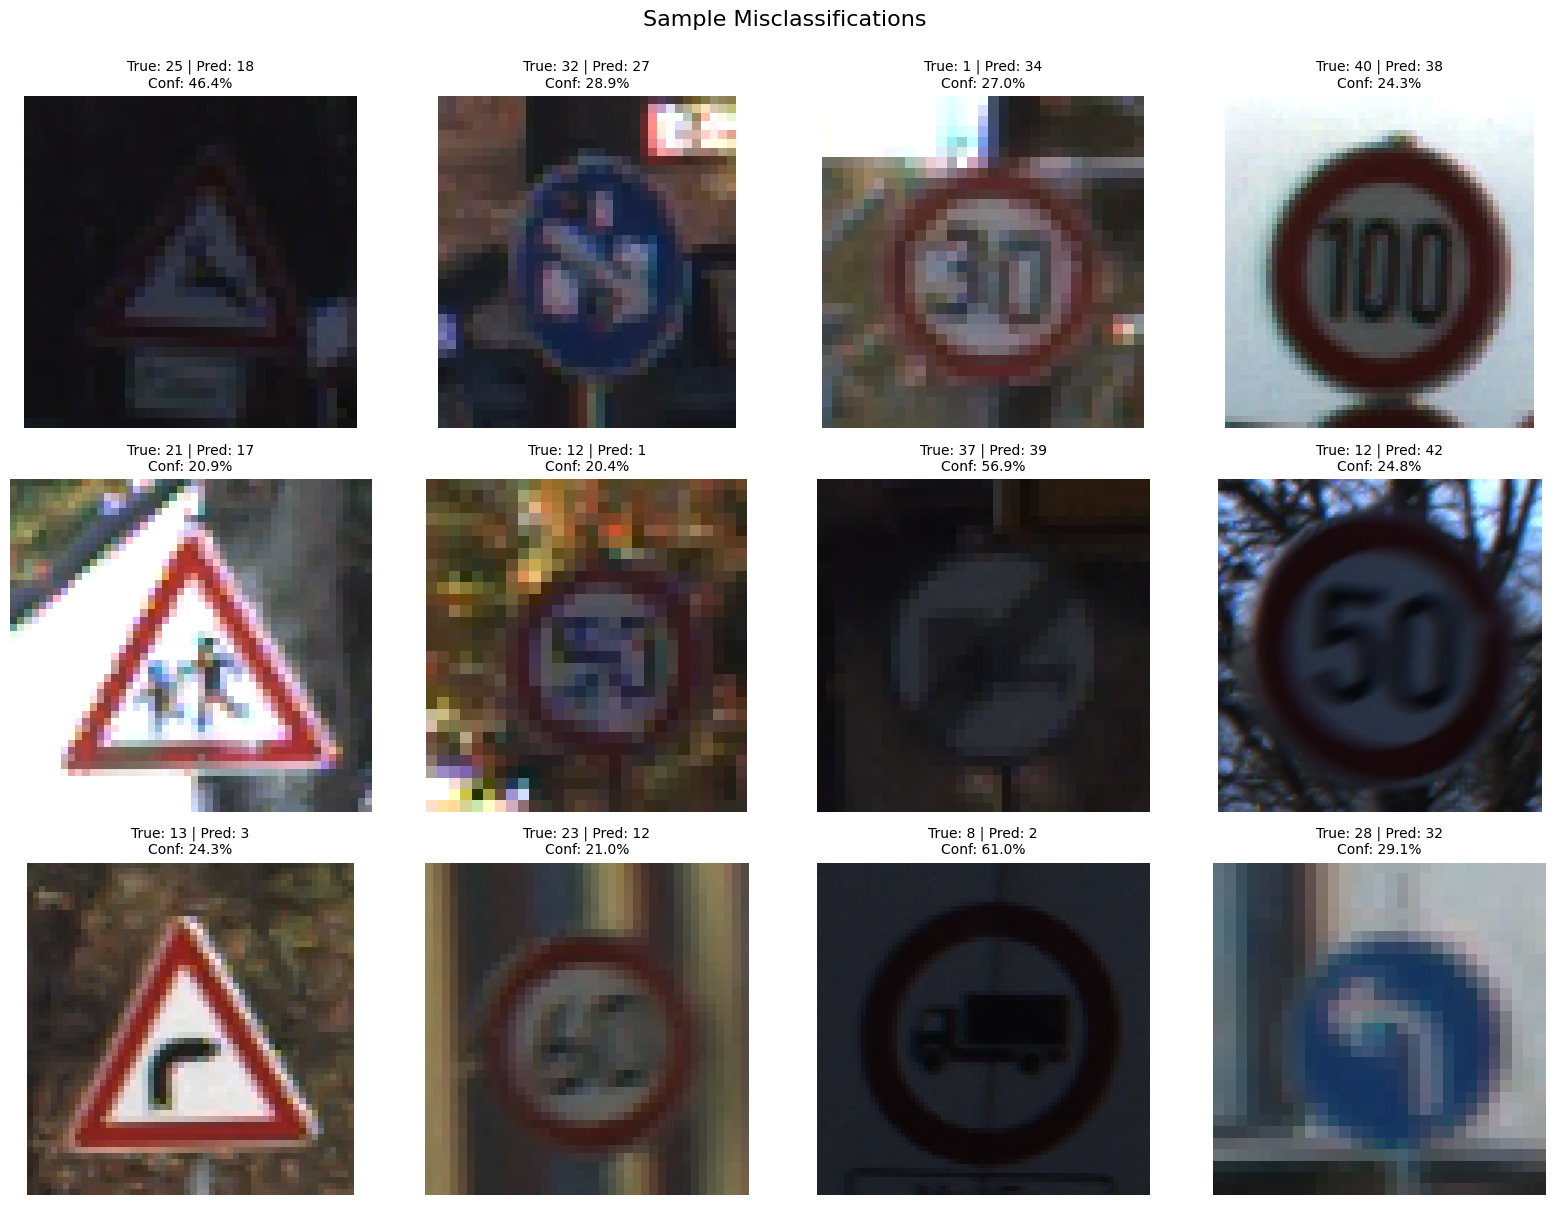

In [ ]:
# ============================================
# 13. ANALYZE MISCLASSIFICATIONS
# ============================================
import random

errors = np.where(y_pred != test_generator.classes)[0]
print(f"\nNumber of misclassified images: {len(errors)} out of {len(y_pred)}")
print(f"Error rate: {len(errors)/len(y_pred)*100:.2f}%")

if len(errors) > 0:
    plt.figure(figsize=(16, 12))
    sample_errors = random.sample(list(errors), min(12, len(errors)))

    for i, idx in enumerate(sample_errors):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        true_label = test_generator.classes[idx]
        pred_label = y_pred[idx]
        confidence = Y_pred[idx][pred_label] * 100

        plt.title(f"True: {true_label} | Pred: {pred_label}\nConf: {confidence:.1f}%",
                  fontsize=10)
        plt.axis('off')

    plt.suptitle('Sample Misclassifications', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig('misclassifications.png', dpi=300, bbox_inches='tight')
    plt.show()

Save the Model

In [ ]:
# model.save('resnet_traffic_signs.h5')

# ============================================
# 14. SAVE FINAL MODEL
# ============================================
model.save('optimized_resnet50_traffic_signs.h5')
print("\n✅ Model saved as 'optimized_resnet50_traffic_signs.h5'")



✅ Model saved as 'optimized_resnet50_traffic_signs.h5'
